In [ ]:
import tensorflow as tf
import zipfile,os,shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tq
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O rockpaperscissor.zip

--2020-06-05 10:51:10--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissor.zip’

rockpaperscissor.zi 100%[===================>] 307.92M  7.31MB/s    in 71s     

2020-06-05 10:52:22 (4.33 MB/s) - ‘rockpaperscissor.zip’ saved [322873683/322873683]



In [ ]:
zip_ref = zipfile.ZipFile('rockpaperscissor.zip')
zip_ref.extractall()
for i in os.listdir('rockpaperscissors'):
        if i=="README_rpc-cv-images.txt":
           os.remove('rockpaperscissors/README_rpc-cv-images.txt')
           break
for i in os.listdir('rockpaperscissors/rps-cv-images'):
        if i=="README_rpc-cv-images.txt":
            os.remove('rockpaperscissors/rps-cv-images/README_rpc-cv-images.txt')

mypath= 'rockpaperscissors/rps-cv-images'
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
paper       712
rock        726
scissors    750
dtype: int64

In [ ]:
X= df['path']
y= df['tag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=300)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=100)
df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_te = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [ ]:
df_all = df_tr.append([df_te,df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(3)


set         tag     
test        paper        74
            rock         70
            scissors     75
train       paper       569
            rock        573
            scissors    608
validation  paper        69
            rock         83
            scissors     67
dtype: int64 




,path,tag,set
446,rockpaperscissors/rps-cv-images/paper/PDV8vSlS...,paper,train
985,rockpaperscissors/rps-cv-images/rock/gaZKijiVX...,rock,train
1349,rockpaperscissors/rps-cv-images/rock/rLOijBMEY...,rock,train


In [ ]:

datasource_path = mypath
dataset_path = "dataset/"
for index, row in tq(df_all.iterrows()):
    
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dim = (150, 150)
channel = (3, )
input_shape = dim + channel

batch_size = 16
epoch = 10

train_datagen =ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range=20,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 1750 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


In [ ]:
num_class = test_generator.num_classes
labels = train_generator.class_indices.keys()
print(labels)

dict_keys(['paper', 'rock', 'scissors'])


In [ ]:
from datetime import datetime
from operator import mul
ACCURACY_THRESHOLD = 0.905

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('acc') > ACCURACY_THRESHOLD and logs.get('val_acc') > ACCURACY_THRESHOLD :
			 print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			 self.model.stop_training = True

def getTimeTraining(timeone,timetwo):
    FMT = '%H:%M:%S'
    tdelta = str(datetime.strptime(timetwo, FMT) - datetime.strptime(timeone, FMT))
    factors = (60, 1, 1/60)
    t1 = int(sum(i*j for i, j in zip(map(int, tdelta.split(':')), factors)))
    return t1
    

def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.optimizers import Adam


model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

BatchNormalization(axis = -1)
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
BatchNormalization(axis = -1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3, 3)))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
BatchNormalization(axis=-1)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512))
BatchNormalization()
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_class))
model.add(Activation('softmax'))


model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

callbacks_list = [
    myCallback(),
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_CheckP_rps.h5', monitor='val_loss', save_best_only=True),
]


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 150, 150, 128)     3584      
_________________________________________________________________
activation_42 (Activation)   (None, 150, 150, 128)     0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 148, 148, 64)      73792     
_________________________________________________________________
activation_43 (Activation)   (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
activation_44 (Activation)   (None, 72, 72, 128)      

In [ ]:
from datetime import datetime
FMT = '%H:%M:%S'
s1 = datetime.now().time().strftime(FMT)
print(s1)
spe=60
vs=len(val_generator)
history = model.fit(
        train_data,
        steps_per_epoch=spe,
        epochs=5,
        validation_data=val_data,
        validation_steps=vs,
        callbacks=callbacks_list
    )

s2 = datetime.now().time().strftime(FMT)
print()
print(s2)
tdelta = getTimeTraining(s1,s2)
print("waktu training")
print(tdelta)

10:52:30
Epoch 1/5
60/60 [==============================] - 335s 6s/step - loss: 1.0120 - acc: 0.4688 - val_loss: 0.6676 - val_acc: 0.7489
Epoch 2/5
60/60 [==============================] - 330s 6s/step - loss: 0.4789 - acc: 0.8284 - val_loss: 0.5300 - val_acc: 0.7854
Epoch 3/5
60/60 [==============================] - 337s 6s/step - loss: 0.3127 - acc: 0.8844 - val_loss: 0.3434 - val_acc: 0.8630
Epoch 4/5
60/60 [==============================] - 333s 6s/step - loss: 0.2756 - acc: 0.9063 - val_loss: 0.3484 - val_acc: 0.8721
Epoch 5/5
60/60 [==============================] - ETA: 0s - loss: 0.1995 - acc: 0.9302
Reached 90.50% accuracy, so stopping training!!
60/60 [==============================] - 335s 6s/step - loss: 0.1995 - acc: 0.9302 - val_loss: 0.3104 - val_acc: 0.9132

11:20:48
waktu training
28


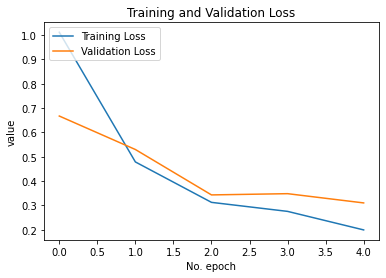

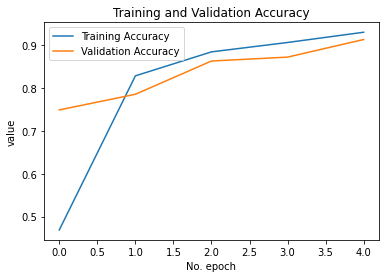

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')
 
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.9315 
Loss on training data: 0.2507 

Accuracy on test data: 0.9452 
Loss on test data: 0.2371 



In [ ]:
from google.colab import files
from keras.preprocessing import image

import requests
from io import BytesIO

from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

uploaded = files.upload()
rpslabels=['paper', 'rock', 'scissors']
for fn in uploaded.keys():
 
  path = fn
  im = Image.open(path)
  X = preprocess(im,(150,150))
  X = reshape([X])
  y = model.predict(X)

print( rpslabels[np.argmax(y)], np.max(y) )

Saving 1MMkSW3f1CAsw03q.png to 1MMkSW3f1CAsw03q (2).png
scissors 0.99979264
